In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Speed-analyzer
Ingest results-cli.csv from speedtest.net cli cron job and display an hourly speed based on the three available samples per hour

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure 
from mpl_toolkits.mplot3d import Axes3D
import time
import datetime    # hope this doesn't mess up time import 
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.cm as cm
import ipywidgets as widgets
import os, sys, subprocess
from pathlib import Path

def analyzeFrame(frm):
    """Analyze a frame for:
    blank rows
    """
    print(f".. Info \n{frm.info()}")
    print(f".. Describe normal\n{frm.describe()}")
    try: 
        print(f".. Describe objects\n{frm.describe(include=np.object)}")
    except ValueError:
        print(f"** Warning. Frame contains no objects to describe")

    for rc in frm.columns:
        #print("===> ",rc) 
        feature = frm.loc[ frm[rc].isna() ]
        #print(f".. F={feature}, LF={len(feature)} " )
        if len(feature) > 0:
            print(f"** {rc:17}{(len(feature)):7}   blank rows")
        else:
            print(f"-- {rc:17} has zero blank rows")
# analyzeFrame(r0)    # example usage

def analyzeCols(frm, cols):
    """Analyze given frame columns as:
        value_counts
    """
    #cols = ['repo_maintained', 'org_type']
    for col in cols: 
        frm[col].unique()
        for u in frm[col].unique():
            print(f".. Column {col}, Value {u}, Count {len( frm.loc[ frm[col] == u ])}")
# analyzeCols(r1, ['repo_maintained', 'org_type'])    # example usage 

def debugCsv(tf, tfname): 
    """Output a consistently named debug file"""
    tf.to_csv(f"debug_{tfname}.csv")

plt.rcParams.update({'figure.max_open_warning': 0})

# Read list of csvs into origin frame, s0
## Minimize to raw data frame w/only info we need, s00

In [3]:
print(f"== SpeedTest_Analyzer ==")
# ─── CONFIG & BOILERPLATE ─────────────────────────────────────────────
env_path = Path('.') / '.env'

# 1) If .env missing → create template and exit
if not env_path.exists():
    env_path.write_text(
        "inputFile=\n"
        "remoteHost=\n"
        "remoteUser=\n"
        "remotePath=\n"
    )
    sys.exit(
        "'.env' created with placeholders. "
        "Please edit it to set inputFile, remoteHost, remoteUser, remotePath, then rerun."
    )

# 2) Read & parse .env
config = {}
for line in env_path.read_text().splitlines():
    if '=' in line and not line.strip().startswith('#'):
        k, v = line.split('=', 1)
        config[k.strip()] = v.strip()

input_file   = config.get('inputFile')
remote_host  = config.get('remoteHost')
remote_user  = config.get('remoteUser')
remote_path  = config.get('remotePath')

# 3) Validate all vars present
missing = [name for name, val in (
    ('inputFile',   input_file),
    ('remoteHost',  remote_host),
    ('remoteUser',  remote_user),
    ('remotePath',  remote_path),
) if not val]
if missing:
    sys.exit(f"Please set {', '.join(missing)} in .env and rerun.")

# ─── SCP PULL ────────────────────────────────────────────────────────
# Build remote spec (ensure single slash between path & file)
remote_spec = f"{remote_user}@{remote_host}:{remote_path.rstrip('/')}/{input_file}"
print(f".. Fetching via command {remote_spec}")
subprocess.run(['scp', remote_spec, '.'], check=True)
print(f".... Retrieved {input_file!r} from {remote_user}@{remote_host} to current directory")


== SpeedTest_Analyzer ==
.. Fetching via command commonadmin@roundtable:/home/commonadmin/projects/speedtest_query/data/results-cli.csv
.... Retrieved 'results-cli.csv' from commonadmin@roundtable to current directory


In [4]:
# s0 is original frame w/as little change as possible 
s0 = pd.concat(pd.read_csv(file, low_memory=False) for file in [input_file])

# create datetimes from local cron timestamp AND server - they appear to be the same
# Case A: local timestamp 
s0['datetime'] = s0.date+' '+s0.time
# Convert date format 2022-01-01 23:59:59 
s0['datetime'] = pd.to_datetime(s0.datetime, format="%Y-%m-%d %H:%M:%S")

# Case B: server timestamp (converting from UTC to Eastern time) 
# Update for newer speedtest-cli version 
def clean_timestamp(ts):
    """Clean timestamp by removing trailing Z if timezone offset is present"""
    if pd.isna(ts):
        return ts
    ts_str = str(ts)
    # If timestamp has timezone offset (+XX:XX or -XX:XX) and ends with Z, remove the Z
    if ('+' in ts_str or ts_str.count('-') > 2) and ts_str.endswith('Z'):
        return ts_str[:-1]
    return ts_str

# Clean the timestamps before parsing
s0['Timestamp_clean'] = s0['Timestamp'].apply(clean_timestamp)

s0['dt'] = pd.to_datetime(
    s0['Timestamp_clean'],
    utc=True,
    errors='coerce'      # turns unparsable (including NaN) into pd.NaT
)
s0['datetime'] = s0['dt'].dt.tz_convert('America/New_York')
if False: debugCsv(s0, "s0")

# s00 is our effective starting frame 
s00 = s0.drop(columns=['date','time','Server ID', "Sponsor", "Server Name", "Timestamp", "Timestamp_clean", "Distance", "Share", "dt"])
s00['Download']=s00['Download']/1000000
s00['Upload']  =s00['Upload']/  1000000
if False: debugCsv(s00, "s00")
s00.head(25)
print(f".. Loading {len(s00)/3/24} days of data, {len(s00)} samples")

.. Loading 1057.013888888889 days of data, 76105 samples


# Identify ISP according to IP Address to frame S1
* ISPs from list below include T-Mobile, Verizon, APB, Starlink 
* Script aborts if an unknown IP address range is encountered 

In [5]:
# Classify IPs by current ISP
s00.loc[s00['IP Address'].isna()==True,'IP Address']="None"      # str function dies on null values
s00['isp']="UNKNOWN"                                             # everyone is unknown unless proven otherwise
s00.loc[s00['IP Address'].str.startswith('172'),'isp']='T-Mobile'
s00.loc[s00['IP Address'].str.startswith('174'),'isp']='Verizon'
s00.loc[s00['IP Address'].str.startswith('64'),'isp']='APB'
s00.loc[s00['IP Address'].str.startswith('184'),'isp']='APB'
s00.loc[s00['IP Address'].str.startswith('98'),'isp']='Starlink'
s00.loc[s00['IP Address'].str.startswith('129'),'isp']='Starlink'
s00.loc[s00['IP Address'].str.startswith('143.105'),'isp']='Starlink'
s00.loc[s00['IP Address'].str.startswith('216.234'),'isp']='Starlink'     
# Display UNKNOWN count which should be 0 
# UKNOWN with a valid IP address indicates a new IP space to classify, this must be zero 
unknownisp_count = s00['isp'].loc[(s00['isp'] == "UNKNOWN") & (s00['IP Address']!="None") ].count()
if unknownisp_count !=0:
    print(f"** Unknown ISPs detected with {unknownisp_count} entries")
    print(f"** ** IPs:\n{s00['IP Address'].loc[(s00['isp'] == 'UNKNOWN') & (s00['IP Address']!='None') ]}")
# UKNOWN without a valid IP address means no data was returned and is likely a test server or network outage 
nodata_count = s00['isp'].loc[(s00['isp'] == "UNKNOWN") & (s00['IP Address']=="None") ].count()
#
print(f"!! Uknown ISPs are   {unknownisp_count}. This should be 0!")
print(f"!! No Data counts is {nodata_count    }. This is FYI only")
assert unknownisp_count==0,"** Unknown ISP by IP Address. Stop and update classification."
# Assert passed, all instances of missing ISP represent No Data 
s00.loc[s00['isp']=="UNKNOWN", 'isp']='NODATA' 

# Starlink speeds incorrect; speculative fix is upload*10 and download*100
#s00.loc[s00['isp']=='Starlink','Upload'] *= 10
#s00.loc[s00['isp']=='Starlink','Download'] *= 100

# Apply the speculative fix for Starlink speeds, but only for dates earlier than 2024
s00.loc[(s00['isp'] == 'Starlink') & (s00['datetime'] < '2024-01-01'), 'Upload'] *= 10
s00.loc[(s00['isp'] == 'Starlink') & (s00['datetime'] < '2024-01-01'), 'Download'] *= 100

if False: debugCsv(s00, "s00a")
if True: s00.to_csv('s00_all-data.csv', index=False)

s00.tail(2)

!! Uknown ISPs are   0. This should be 0!
!! No Data counts is 4383. This is FYI only


,Ping,Download,Upload,IP Address,datetime,isp
76103,68.492,43.954643,26.492256,129.222.2.76,2025-06-13 23:28:01.849593-04:00,Starlink
76104,56.949,64.796708,27.357033,129.222.2.76,2025-06-13 23:48:01.976148-04:00,Starlink


# Create hourly samples frame for plotting

In [6]:
def ispx(isps): 
    """Mark sampled hours MIXED if more than one ISP active 
    """
    if False: print("__ ispx:   ", isps)
    isplist = isps.unique()
    if len(isplist)==1:     # a lone ISP for the period 
        #print("____ ISP selected as ",isplist, len(isplist))
        return str(isplist[0])
    elif len(isplist)==0:    # no data was taken for the whole hour (machine off probably) (no execution)
        return "NODATA"
    else:
        return "MIXED"

# Graph as a timeline and then a 24 hour basis 

In [7]:
def plotTimeline(dt, **kwargs):
    #isp="ALL", save=False):
    """Plot dataframe's whole timeline from start to finish
        isp: String for plot title indicating scope of data; one isp by name or all
        save: Save to disk if True. Intended for terminal runs 
        plotTitleExt: Plot title extension 
        ymin: lowest value plotted 
        ymax: highest value plotted 
        recentDays: print only the last number of days given 
    """
    defaultKwargs = {"isp": "ALL", "save": False, "plotTitleExt": "", "ymin": None, "ymax": None, "recentDays": None}
    kwargs = {**defaultKwargs, **kwargs}
    for key, value in kwargs.items():
        if key == 'isp': 
            isp = value
        elif key == 'save':
            save = value 
        elif key == 'plotTitleExt':
            plotTitleExt = value 
        elif key == 'ymin':
            ymin = value 
        elif key == 'ymax':
            ymax = value
        elif key == 'recentDays':
            recentDays = value
        else:
            raise Exception(f"** Unknown keyword calling plotTimeline, {key}:{value}") 
        
    if isp != "ALL":
        dt=dt.loc[dt['isp']==isp]
    if recentDays: 
        # View recent days only 
        dt = dt.loc[dt['datetime'] >= dt['datetime'].max() - pd.Timedelta(days=recentDays)]
    
    
    fig,ax1=plt.subplots(1,1,figsize=(16,10))
    ax1.set_title(f"Performance Timeline for ISP={isp}{plotTitleExt}")
    
    if False: dt.to_csv(f"debug_dtl_{isp}.csv")
    ax1.plot(dt['datetime'], dt['Download'],linewidth=0, marker='.', markersize=3, color='red', label="Download")
    ax1.plot(dt['datetime'], dt['Upload'],linewidth=0, marker='.', markersize=3, color='blue', label="Upload")
    ax1.set_xlabel('Timeline by month, day, hour')
    ax1.set_ylabel(f"Upload (negative values) and Download (positive values) Mbps for ISP={isp}")
    ax1.legend(loc="upper left")
    ax1.axhline(y=0, color="k")
    ax1.grid()
    if ymin: ax1.set_ylim(bottom=ymin)
    if ymax: ax1.set_ylim(top=ymax)
    ax1.tick_params(axis='x', labelrotation=45)
    if save: fig.savefig(f'Timeline-for-{isp}{plotTitleExt.replace(",","_")}.png') 
    
def plot24(dt, **kwargs):
    """Plot an IPS's performance on a 24-hour basis (ignoring dates) to see daily patterns
        isp: String for plot title indicating scope of data; one isp by name or all
        save: Save to disk if True. Intended for terminal runs 
        isp: String for plot title indicating scope of data; one isp by name or all
        save: Save to disk if True. Intended for terminal runs 
        plotTitleExt: Plot title extension 
        ymin: lowest value plotted 
        ymax: highest value plotted 
        recentDays: print only the last number of days given 
    """
    defaultKwargs = {"isp": "ALL", "save": False, "plotTitleExt": "", "ymin": None, "ymax": None, "recentDays": None}
    kwargs = {**defaultKwargs, **kwargs}
    for key, value in kwargs.items():
        if key == 'isp': 
            isp = value
        elif key == 'save':
            save = value 
        elif key == 'plotTitleExt':
            plotTitleExt = value 
        elif key == 'ymin':
            ymin = value 
        elif key == 'ymax':
            ymax = value
        elif key == 'recentDays':
            recentDays = value
        else:
            raise Exception(f"** Unknown keyword calling plotTimeline, {key}:{value}") 
    
    if isp != "ALL":
        dt=dt.loc[dt['isp']==isp]
    if recentDays: 
        # View recent days only 
        dt = dt.loc[dt['datetime'] >= dt['datetime'].max() - pd.Timedelta(days=recentDays)]
        
    fig,ax1=plt.subplots(1,1,figsize=(16,10))
    ax1.set_title(f"24-Hour Performance for ISP={isp}{plotTitleExt}")
    
    if False: dt.to_csv(f"debug_d24_{isp}.csv")
    ax1.plot(dt['time'], dt['Download'],linewidth=0, marker='.', markersize=3, color='red', label="Download")
    #ax1.plot(dt['time'], dt['down20'],linewidth=0, marker='*', markersize=9, color='black', label="Download 20% Quant")
    ax1.plot(dt['time'], dt['Upload'],linewidth=0, marker='.', markersize=3, color='blue', label="Upload")
    ax1.set_xlabel('24 Hour View from Midnight (0) to 11 PM (23)')
    ax1.set_ylabel(f"Upload (negative values) and Download (positive values) Mbps for ISP={isp}")
    ax1.legend(loc="upper left")
    ax1.axhline(y=0, color="k")
    ax1.grid()
    if ymin: ax1.set_ylim(bottom=ymin)
    if ymax: ax1.set_ylim(top=ymax)
    ax1.tick_params(axis='x', labelrotation=45)
    if save: fig.savefig(f'24-Hour-for-{isp}{plotTitleExt.replace(",","_")}.png') 

# test block 
if False: 
    plotTimeline(s21)
    plotTimeline(s21, isp="APB", ymin=-5, ymax=20, plotTitleExt=", broadband values -5 to 20 Mbps", save=True)
    plotTimeline(s21, recentDays=7, plotTitleExt=", last 7 days")

if False:
    plot24(s21)
    plot24(s21, isp="APB", ymin=-5, ymax=20, plotTitleExt=", broadband values -5 to 20 Mbps", save=True)
    plot24(s21, recentDays=7, plotTitleExt=", last 7 days")
    #plot24(s21, "APB", True)

In [8]:
def q20(x): 
    '''Return the 20% quantile value for a column'''
    return x.quantile(0.2)

# form s21 as an hourly frame
s21 = s00.set_index('datetime')
s21['down20'] = s21['Download']     # Does not really do what I hoped ####
s21 = s21.resample('1h', origin='start_day').agg({'Ping':'mean','Download':'mean', 'Upload':'mean', 'down20': q20, 'isp':ispx})
s21['Upload']=s21['Upload']*-1
s21.reset_index(inplace=True)
s21['time']=s21['datetime'].dt.time.astype(str)
s21.sort_values('time', inplace=True)
#s21.set_index('time',inplace=True)

if True: s21.to_csv('s21_hourly-data.csv', index=False)
s21.head(2)

,datetime,Ping,Download,Upload,down20,isp,time
24879,2025-01-26 00:00:00-05:00,NaN,NaN,NaN,NaN,NODATA,00:00:00
17558,2024-03-27 00:00:00-04:00,39.564667,25.406432,-5.526886,25.323241,APB,00:00:00


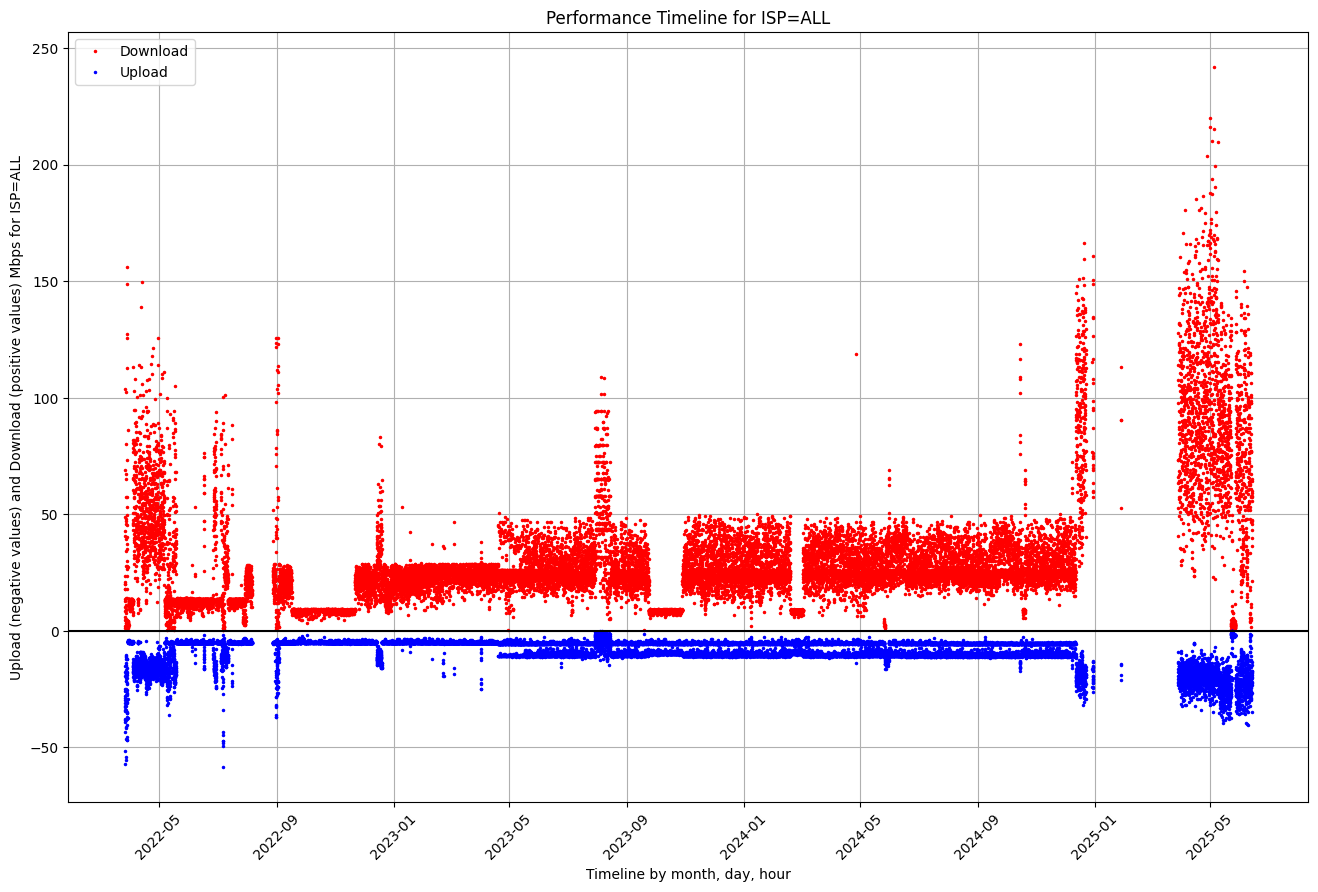

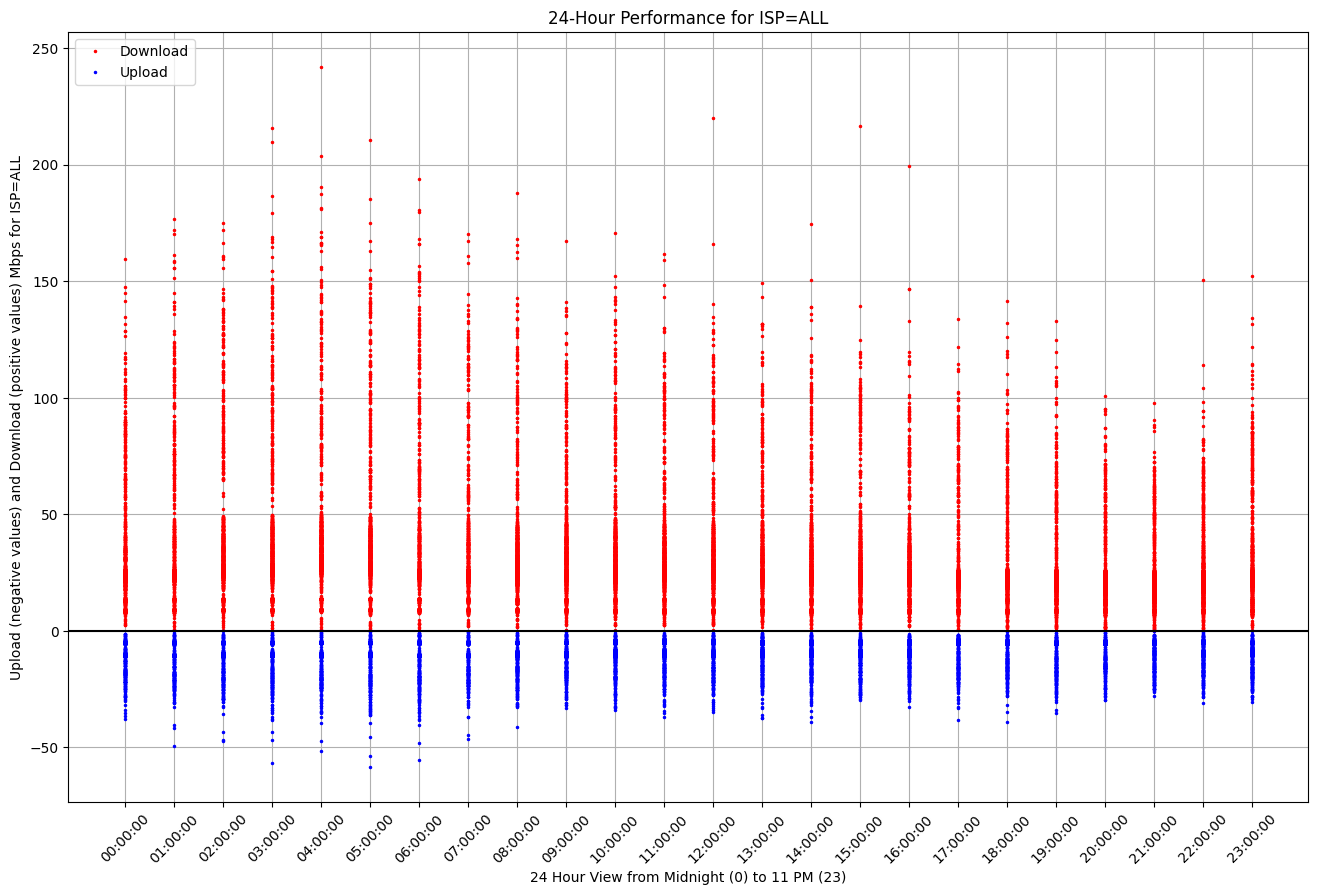

In [9]:
if True: 
    # plot full timeline 
    plotTimeline(s21,save=True)
    plot24(s21, save=True)

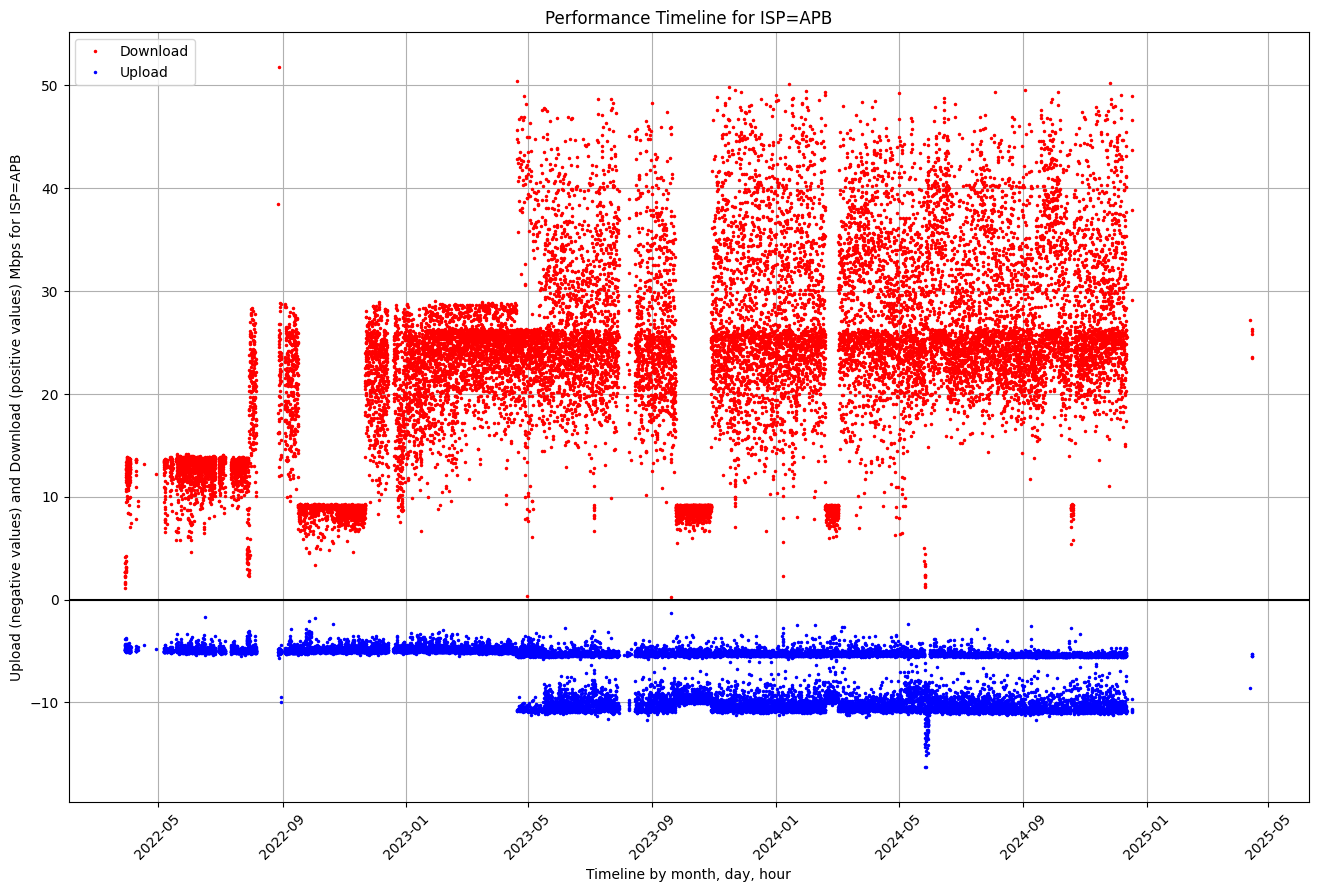

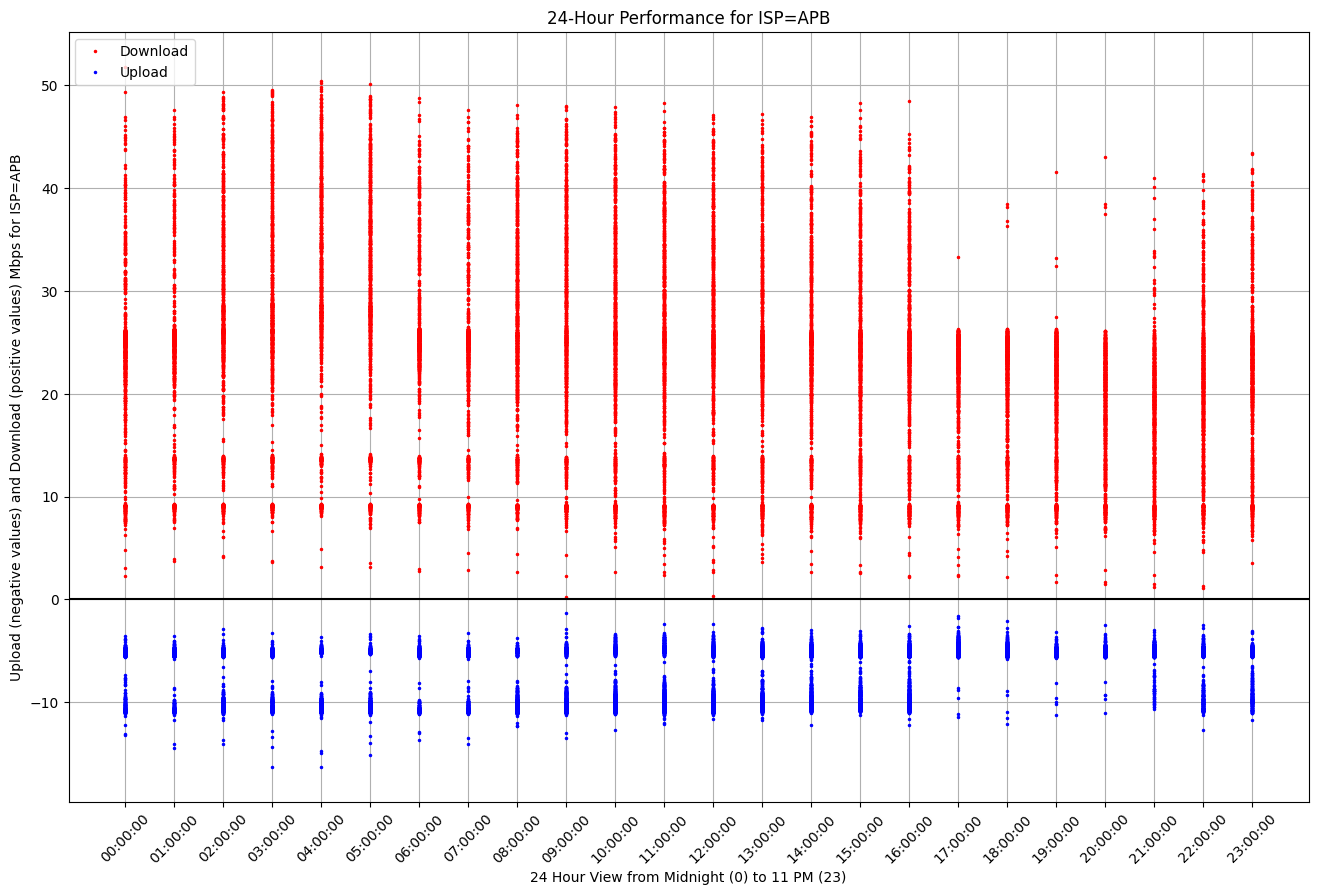

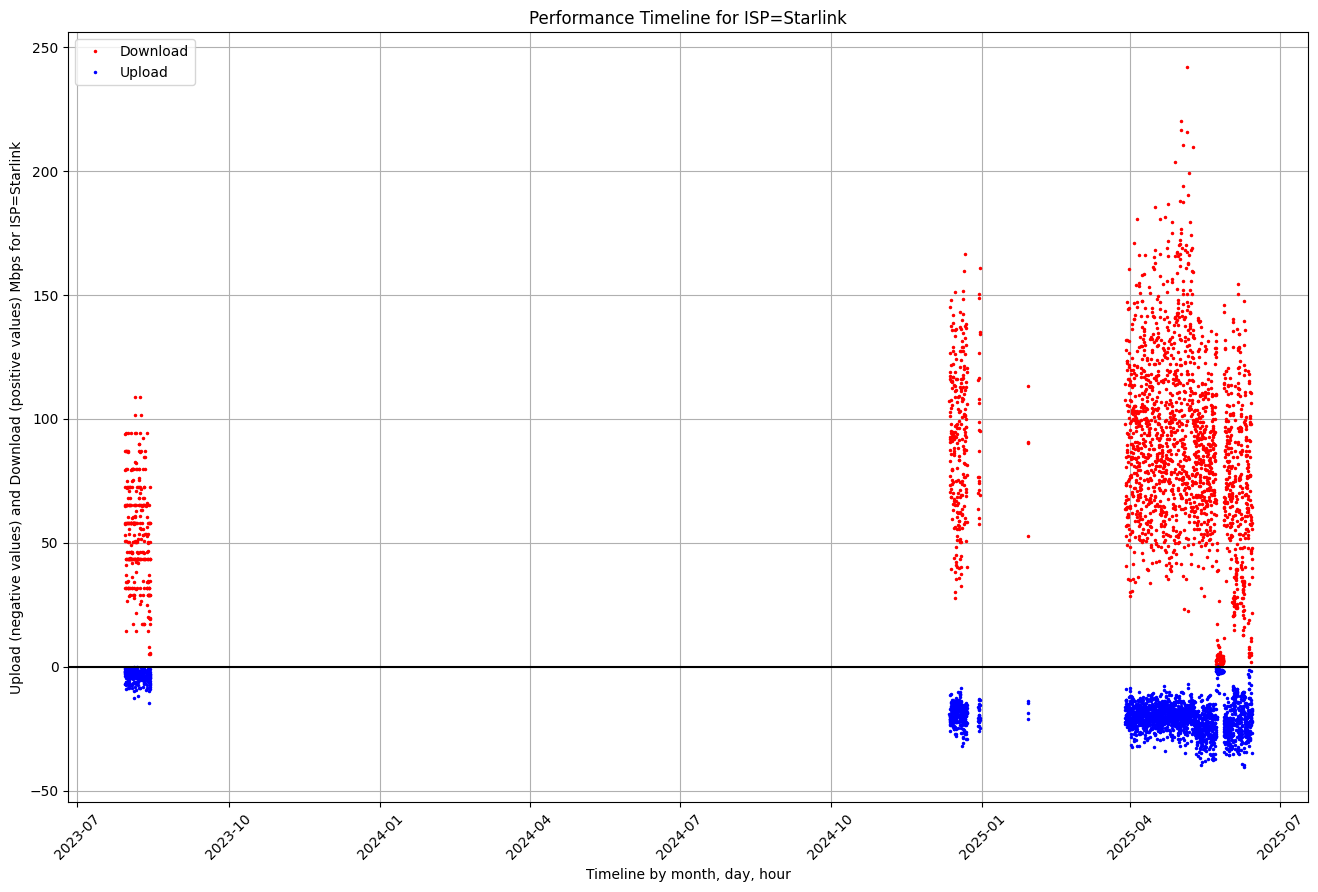

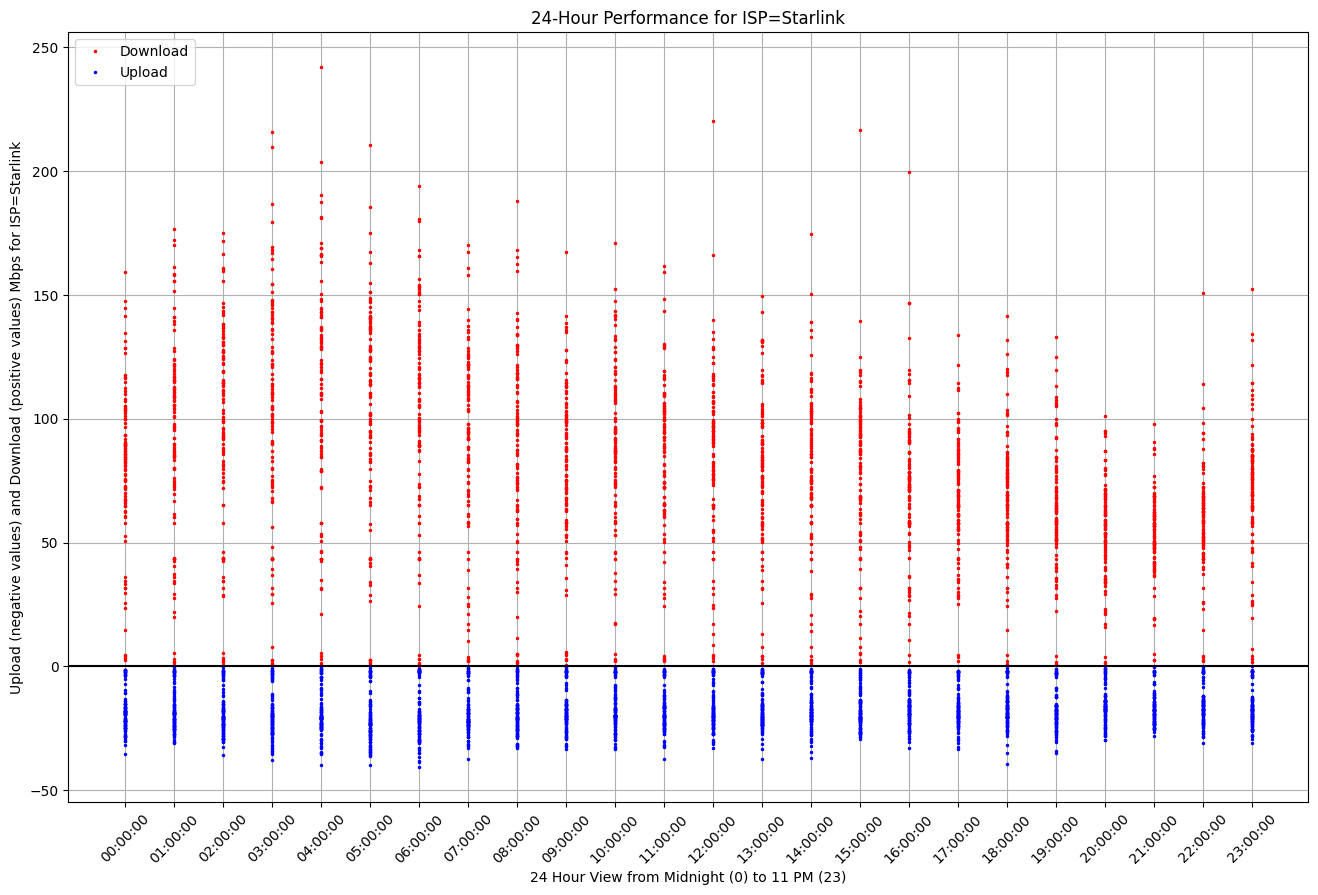

In [10]:
# manually plot full timeline by each ISP
if True:
    plotTimeline(s21,isp="APB",save=True)
    plot24(s21, isp="APB", save=True)
    plotTimeline(s21,isp="Starlink",save=True)
    plot24(s21, isp="Starlink", save=True)

if False:
    plotTimeline(s21,isp="T-Mobile",save=True)
    plot24(s21, isp="T-Mobile", save=True)
    plotTimeline(s21,isp="Verizon",save=True)
    plot24(s21, isp="Verizon", save=True)

# cycle plot full timeline by each ISPs (MIXED and NODATA aren't that useful)
if False: 
    # cycle through all ISPs 
    for isp in s21['isp'].unique():
        plotTimeline(s21,isp=isp, save=True)
        plot24(s21, isp=isp, save=True)

# Prepare a special view for T-Mobile 
* Limit axes to Industry bounds of 25/3 for "broadband" 
* This was interesting when T-Mobile was claiming $50 unlimited broadband via cellular. It wasn't even close. 

In [11]:
if False:
    plotTimeline(s21,isp="T-Mobile",save=True, ymin=-5, ymax=15, plotTitleExt=", scaled to broadband range -5 to 15 Mbps")
    plot24(s21, isp="T-Mobile", save=True, ymin=-5, ymax=15, plotTitleExt=", scaled to broadband range -5 to 15 Mbps")

# APB long term and last N days
* All Points Broadband (wireless) is now a secondary provider. So...not interesting

In [12]:
if False:
    plotTimeline(s21,isp="APB",save=True, ymin=-10, ymax=30, plotTitleExt=", scaled to broadband range -10 to 30 Mbps")
    plot24(s21, isp="APB", save=True, ymin=-10, ymax=30, plotTitleExt=", scaled to broadband range -10 to 30 Mbps")
    
if False:
    plotTimeline(s21,isp="APB",save=True, ymin=-10, ymax=30, recentDays=7, plotTitleExt=", scaled to broadband range -10 to 30 Mbps for last 7 days")
    plot24(s21, isp="APB", save=True, ymin=-10, ymax=30, recentDays=7, plotTitleExt=", scaled to broadband range -10 to 30 Mbps for last 7 days")
    
if False:
    plotTimeline(s21,isp="APB",save=True, recentDays=7, plotTitleExt=", for last 7 days")
    plot24(s21, isp="APB", save=True, recentDays=7, plotTitleExt=", for last 7 days")
    
if False:
    plotTimeline(s21,isp="APB",save=True, recentDays=45, plotTitleExt=", for last 45 days")
    plot24(s21, isp="APB", save=True, recentDays=45, plotTitleExt=", for last 45 days")


# Starlink
* Currently, primary provider 

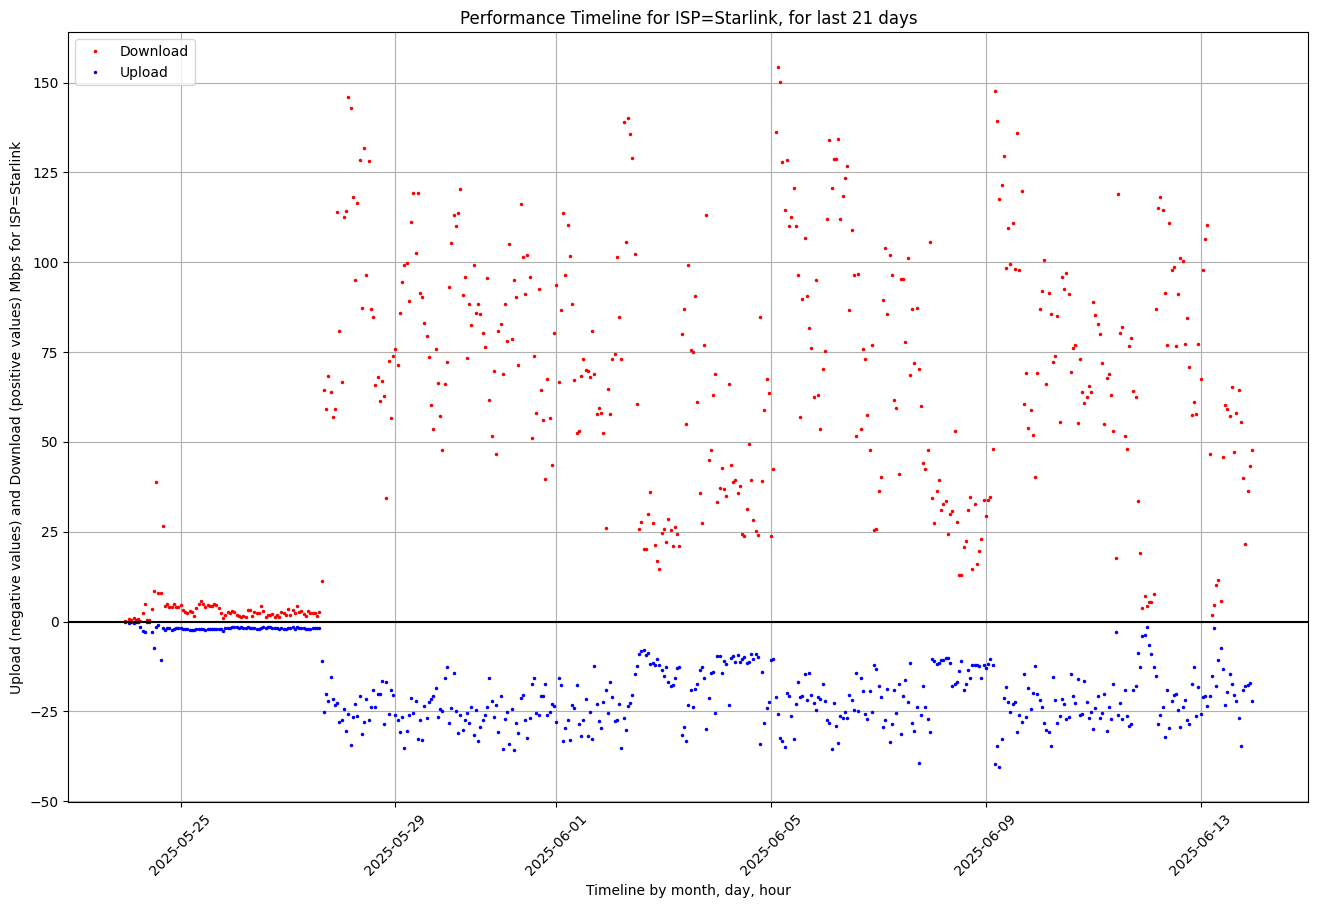

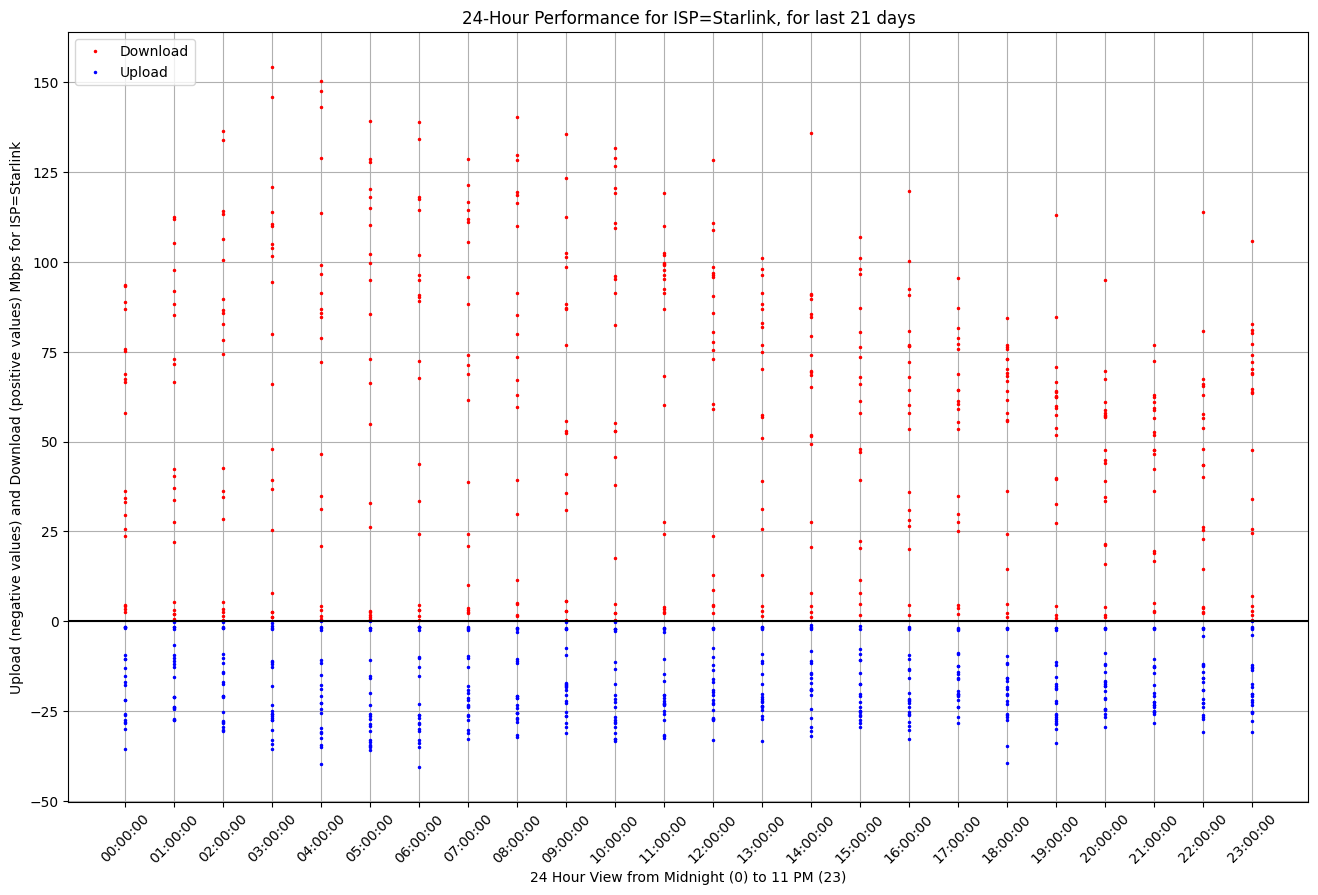

In [13]:
if False:
    plotTimeline(s21,isp="Starlink",save=True, plotTitleExt=", all time")
    plot24(s21, isp="Starlink", save=True, plotTitleExt=", all time")
    
if True:
    lastdays=21 
    plotTimeline(s21,isp="Starlink",save=True, recentDays=lastdays, plotTitleExt=f", for last {lastdays} days")
    plot24(s21, isp="Starlink", save=True, recentDays=lastdays, plotTitleExt=f", for last {lastdays} days")

if False:
    plotTimeline(s21,isp="Starlink",save=True, ymin=-10, ymax=30, plotTitleExt=", scaled to broadband range -10 to 30 Mbps")
    plot24(s21, isp="Starlink", save=True, ymin=-10, ymax=30, plotTitleExt=", scaled to broadband range -10 to 30 Mbps")


# Last N days for all connections 

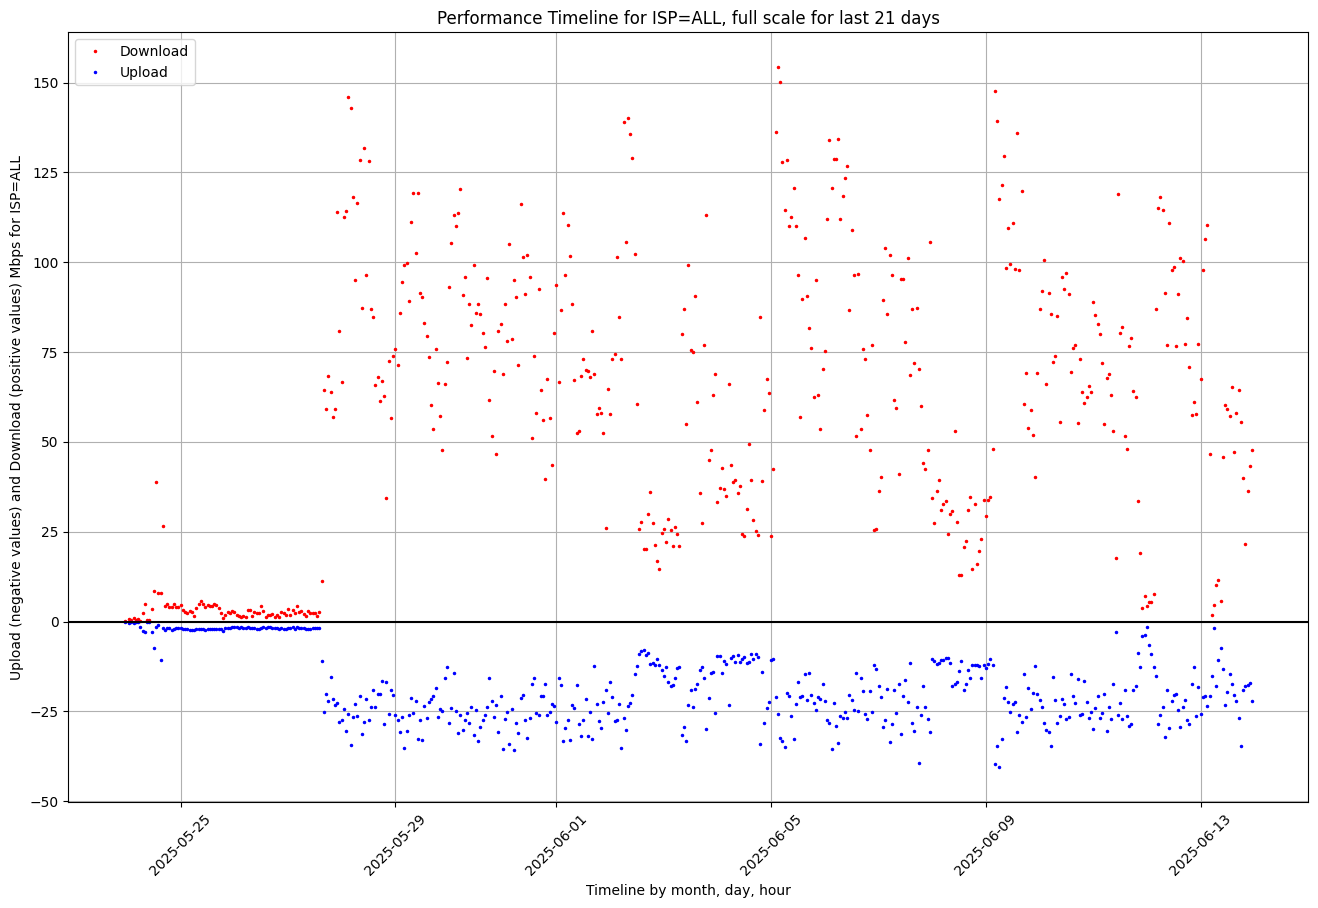

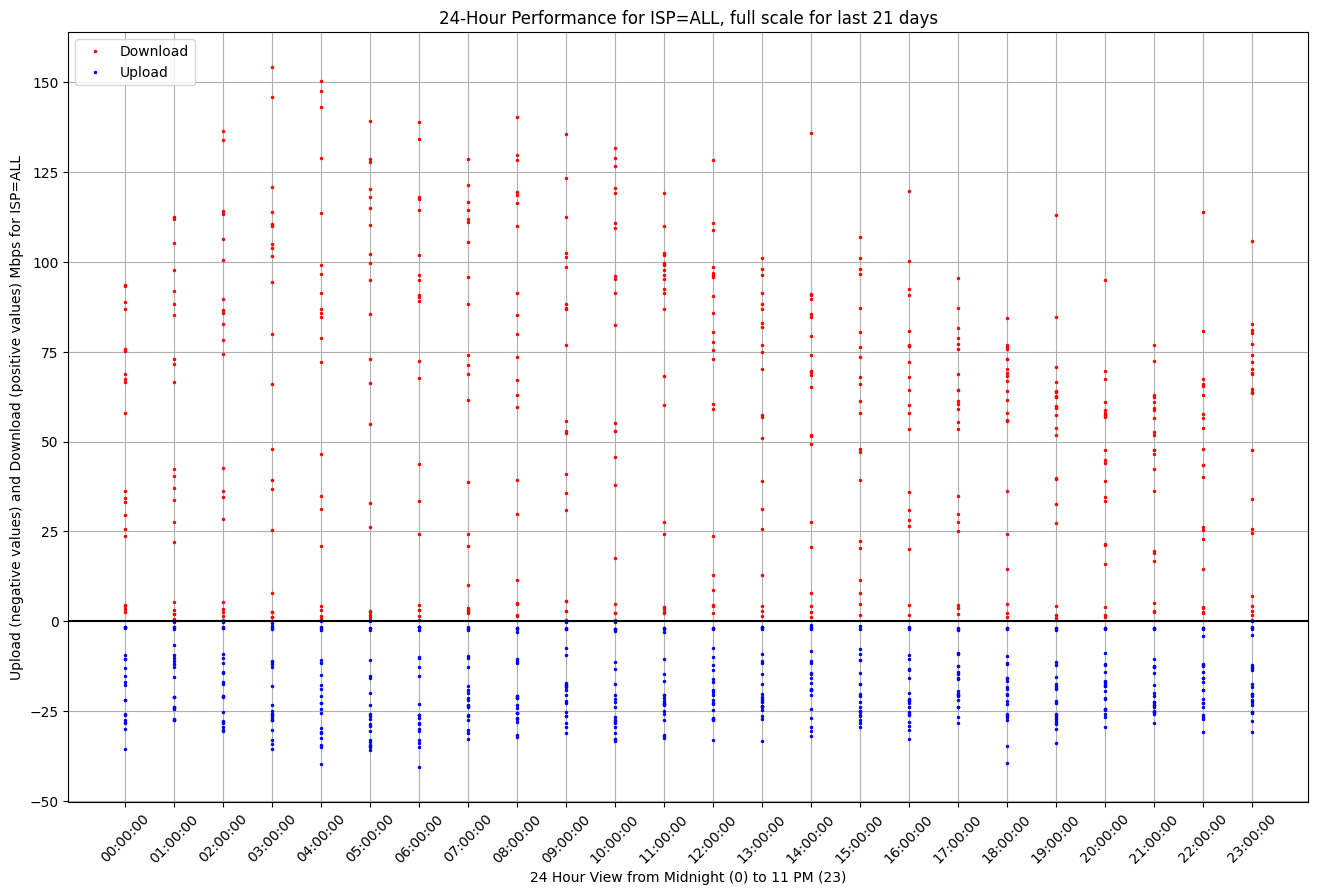

In [14]:
if False:
    plotTimeline(s21,save=True, ymin=-10, ymax=30, recentDays=14, plotTitleExt=", scaled to broadband range -10 to 30 Mbps for last 14 days")
    plot24(s21, save=True, ymin=-10, ymax=30, recentDays=14, plotTitleExt=", scaled to broadband range -10 to 30 Mbps for last 14 days")
if True:
    lastdays=21
    plotTimeline(s21,save=True, recentDays=lastdays, plotTitleExt=f", full scale for last {lastdays} days")
    plot24(s21, save=True, recentDays=lastdays, plotTitleExt=f", full scale for last {lastdays} days")